In [3]:
import os
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd


def prepare_data(
    results_path: str = "results.csv",
    races_path: str = "races.csv",
    drivers_path: Optional[str] = "drivers.csv",
    driver_to_idx: Optional[Dict[int, int]] = None,
    year_from: Optional[int] = None,
    val_fraction: float = 0.20,
    seed: int = 42,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
) -> dict:
    """
    Wczytuje dane, filtruje po roku lub zakresie dat (start_date–end_date),
    buduje rankingi Plackett–Luce i dzieli je na TRAIN/VAL po całych wyścigach.
    Dodatkowo wypisuje podstawowe statystyki okna czasowego.
    """
    # --- load ---
    df = pd.read_csv(results_path, na_values="\\N")
    races_df = pd.read_csv(races_path)

    # --- attach date ---
    df = df.merge(races_df[["raceId", "date"]], on="raceId", how="left")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # --- filter by year or date window ---
    if start_date is not None:
        df = df[df["date"] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df = df[df["date"] < pd.to_datetime(end_date)]
    if year_from is not None and start_date is None and end_date is None:
        df = df[df["date"].dt.year >= int(year_from)]

    # --- dtypes & cleanup ---
    for col in ["raceId", "driverId", "positionOrder"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.dropna(subset=["raceId", "driverId", "positionOrder"]).copy()
    df["raceId"] = df["raceId"].astype(int)
    df["driverId"] = df["driverId"].astype(int)
    df["positionOrder"] = df["positionOrder"].astype(int)

    # --- mappings ---
    if driver_to_idx is None:
        unique_drivers = np.sort(df["driverId"].unique())
        driver_to_idx = {d: i for i, d in enumerate(unique_drivers)}

    idx_to_driver = {i: d for d, i in driver_to_idx.items()}
    n_items = len(driver_to_idx)
    df["driverIndex"] = df["driverId"].map(driver_to_idx)

    # --- build rankings per race ---
    rankings_by_race = {}
    for race_id, g in df.groupby("raceId", sort=True):
        g_sorted = g.sort_values("positionOrder", kind="mergesort")
        if len(g_sorted) >= 2:
            rankings_by_race[int(race_id)] = tuple(g_sorted["driverIndex"].tolist())

    # --- split races chronologicznie (lepsze do time-based validation) ---
    rng = np.random.RandomState(seed)
    all_races = np.array(sorted(rankings_by_race.keys()))
    val_size = max(1, int(len(all_races) * float(val_fraction)))
    races_sorted = (
        df[["raceId", "date"]]
        .drop_duplicates("raceId")
        .sort_values("date")
        .reset_index(drop=True)
    )
    split_idx = len(races_sorted) - val_size
    train_races = races_sorted["raceId"].iloc[:split_idx].tolist()
    val_races = races_sorted["raceId"].iloc[split_idx:].tolist()

    train_rankings = [rankings_by_race[r] for r in train_races if r in rankings_by_race]
    val_rankings = [rankings_by_race[r] for r in val_races if r in rankings_by_race]

    # --- summary stats ---
    total_comparisons = sum(len(r) * (len(r) - 1) // 2 for r in rankings_by_race.values())
    print("📅 Zakres danych:", 
          f"{start_date or min(df['date']).date()} → {end_date or max(df['date']).date()}")
    print(f"🏎️  Liczba wyścigów: {len(rankings_by_race)}")
    print(f"👥  Liczba kierowców: {n_items}")
    print(f"⚔️  Liczba par porównań: {total_comparisons:,}")
    print(f"Train races: {len(train_races)}, Val races: {len(val_races)}\\n")

    # --- optional drivers metadata ---
    drivers_df = None
    if drivers_path and os.path.exists(drivers_path):
        try:
            drivers_df = pd.read_csv(drivers_path)
        except Exception:
            drivers_df = None

    return {
        "train_rankings": train_rankings,
        "val_rankings": val_rankings,
        "driver_to_idx": driver_to_idx,
        "idx_to_driver": idx_to_driver,
        "n_items": n_items,
        "train_races": sorted(train_races),
        "val_races": sorted(val_races),
        "df": df,
        "drivers_df": drivers_df,
    }

def init_mapping_and_theta(
    results_path: str = "results.csv",
    races_path: str = "races.csv",
    start_date: str | None = None,
    end_date: str | None = None,
):
    """
    Wczytuje dane, filtruje po zakresie dat [start_date, end_date),
    zwraca:
      - driver_to_idx: {driverId -> idx} dla kierowców aktywnych w oknie
      - idx_to_driver: {idx -> driverId}
      - theta: wektor zer o długości liczby kierowców w oknie
    """
    # wczytaj
    df = pd.read_csv(results_path, na_values="\\N")
    races = pd.read_csv(races_path, usecols=["raceId", "date"])
    races["date"] = pd.to_datetime(races["date"], errors="coerce")

    # połącz daty z wynikami
    df = df.merge(races, on="raceId", how="left")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    # filtr dat
    if start_date is not None:
        df = df[df["date"] >= pd.to_datetime(start_date)]
    if end_date is not None:
        df = df[df["date"] < pd.to_datetime(end_date)]

    # wyczyść i policz aktywnych
    df = df.dropna(subset=["driverId"])
    driver_ids = (
        df["driverId"]
        .astype(int)
        .drop_duplicates()
        .sort_values()
        .to_numpy()
    )

    # mapping tylko dla kierowców, którzy WYSTĄPILI w tym oknie
    driver_to_idx = {d: i for i, d in enumerate(driver_ids)}
    idx_to_driver = {i: d for d, i in driver_to_idx.items()}

    # puste theta (zerowe)
    theta = np.zeros(len(driver_ids), dtype=float)

    return driver_to_idx, idx_to_driver, theta

In [4]:
import os
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd


# =============================
# Evaluation
# =============================
import numpy as np
from typing import List, Tuple, Dict

def precision_at_k(rankings_true: List[Tuple[int, ...]], theta: np.ndarray, k: int = 5) -> float:
    """
    Precision@K (bez uwzględniania kolejności) dla modelu Plackett–Luce.

    Mierzy, jaki procent przewidzianych top-K uczestników pokrywa się
    z faktycznym top-K w danych, niezależnie od kolejności.

    Parametry
    ----------
    rankings_true : list[tuple[int]]
        Lista rankingów (każdy to krotka indeksów zawodników od zwycięzcy do ostatniego).
        Przykład: [(0, 1, 2), (3, 2, 1, 0)]
    theta : np.ndarray
        Wektor umiejętności / log-szans modelu (większe = lepsze).
    k : int
        Liczba pozycji w top-K, które bierzemy pod uwagę (domyślnie 5).

    Zwraca
    -------
    float
        Średnie Precision@K (0–1). Zwraca NaN, jeśli brak danych.
    """
    if k <= 0:
        return float("nan")

    scores = []
    for r in rankings_true:
        if len(r) < k:
            continue

        idx = list(r)
        vals = theta[idx]

        # top-K wg danych (ground truth) → pierwsze K elementów w rankingu
        topk_true = set(idx[:k])
        # top-K wg modelu (najwyższe wartości theta)
        topk_pred = set([idx[i] for i in np.argsort(-vals)[:k]])

        # część wspólna / K
        overlap = len(topk_true & topk_pred) / k
        scores.append(overlap)

    return float(np.mean(scores)) if scores else float("nan")

def recall_at_k(rankings_true: List[Tuple[int, ...]], theta: np.ndarray, k: int = 5) -> float:
    """
    Recall@K dla modelu rankingowego (np. Plackett–Luce).
    Mierzy, jaki procent prawdziwych top-K uczestników
    znajduje się w modelowym top-K (bez względu na kolejność).
    """
    if k <= 0:
        return float("nan")

    recalls = []
    for r in rankings_true:
        if len(r) < k:
            continue

        idx = list(r)
        vals = theta[idx]

        topk_true = set(idx[:k])
        topk_pred = set([idx[i] for i in np.argsort(-vals)[:k]])

        recalls.append(len(topk_true & topk_pred) / len(topk_true))

    return float(np.mean(recalls)) if recalls else float("nan")

def _mean_loglik_per_choice(rankings, theta):
    """
    Zwraca średni log-likelihood na krok (wybór pozycji) w rankingach PL.
    Przydatne, by porównywać LL niezależnie od liczby wyścigów i długości rankingów.
    """
    steps = sum(max(0, len(r) - 1) for r in rankings)
    if steps == 0:
        return float("nan")
    ll = 0.0
    for r in rankings:
        vals = theta[list(r)]
        for i in range(len(r) - 1):
            m = np.max(vals[i:])
            ll += (vals[i] - m) - np.log(np.sum(np.exp(vals[i:] - m)))
    return ll / steps

def _top1_metrics(rankings, theta):
    """
    Zwraca krotkę: (top1_logloss, top1_accuracy)
    - top1_logloss: średni cross-entropy loss dla przewidywanego zwycięzcy
    - top1_accuracy: odsetek przypadków, gdzie model poprawnie wskazał zwycięzcę
    """
    n = 0
    ce = 0.0
    acc = 0
    for r in rankings:
        vals = theta[list(r)]
        m = np.max(vals)
        log_probs = vals - m - np.log(np.sum(np.exp(vals - m)))
        ce -= log_probs[0]                # cross-entropy dla faktycznego zwycięzcy
        acc += int(np.argmax(vals) == 0)  # czy model przewidział zwycięzcę
        n += 1
    if n == 0:
        return float("nan"), float("nan")
    return ce / n, acc / n

def _log_likelihood_safe(rankings: List[Tuple[int, ...]], theta: np.ndarray) -> float:
    """Numerically stable log-likelihood of Plackett–Luce for full rankings (sum over races)."""
    ll = 0.0
    for r in rankings:
        vals = theta[list(r)]
        for i in range(len(r) - 1):
            m = np.max(vals[i:])
            ll += (vals[i] - m) - np.log(np.sum(np.exp(vals[i:] - m)))
    return float(ll)


def _pairwise_accuracy(rankings: List[Tuple[int, ...]], theta: np.ndarray) -> float:
    total, correct = 0, 0
    for r in rankings:
        idx = list(r)
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                total += 1
                if theta[idx[i]] > theta[idx[j]]:
                    correct += 1
    return correct / total if total else float("nan")


def _brier_pairwise(rankings: List[Tuple[int, ...]], theta: np.ndarray) -> float:
    total = 0
    sse = 0.0
    for r in rankings:
        idx = list(r)
        vals = theta[idx]
        for i in range(len(idx)):
            for j in range(i + 1, len(idx)):
                pa = 1.0 / (1.0 + np.exp(vals[j] - vals[i]))  # P(i precedes j)
                sse += (1.0 - pa) ** 2  # observed: i precedes j in the data
                total += 1
    return sse / total if total else float("nan")


def _topk_hit_rate(rankings: List[Tuple[int, ...]], theta: np.ndarray, k: int = 3) -> float:
    """HitRate@k: is the actual winner (r[0]) within model's top-k by theta among
    the same contestants?"""
    if k <= 0:
        return float("nan")
    hits, n = 0, 0
    for r in rankings:
        idx = list(r)
        vals = theta[idx]
        top_k = np.argsort(-vals)[: min(k, len(idx))]
        hits += int(0 in top_k)  # winner is at position 0 in r
        n += 1
    return hits / n if n else float("nan")

def baseline_random_top1(val_rankings):
    # ~1 / avg field size
    sizes = [len(r) for r in val_rankings if len(r) > 0]
    return (1.0 / np.mean(sizes)) if sizes else float("nan")

def baseline_always_favorite_top1(train_rankings, val_rankings, theta):
    # wybieramy globalnego faworyta wg thety z TRAIN
    # i sprawdzamy, jak często on wygrywa na VAL
    fav = int(np.argmax(theta))
    wins, n = 0, 0
    for r in val_rankings:
        if len(r) == 0: 
            continue
        # zwycięzca w danych to r[0]; sprawdź czy to fav
        wins += int(r[0] == fav)
        n += 1
    return wins / n if n else float("nan")

def per_race_pred_winner(rankings, theta):
    rows = []
    for r in rankings:
        idx = list(r)
        vals = theta[idx]
        m = np.max(vals)
        log_probs = vals - m - np.log(np.sum(np.exp(vals - m)))
        p = np.exp(log_probs)             # rozkład PL wśród uczestników
        pred = int(np.argmax(vals))       # index w obrębie r
        rows.append({
            "winner_true_pos0": idx[0],
            "predicted":        idx[pred],
            "p_predicted":      float(p[pred]),
            "p_true_winner":    float(p[0]),
            "field_size":       len(idx),
        })
    return pd.DataFrame(rows)

def stochastic_top1_accuracy(rankings: List[Tuple[int, ...]], theta: np.ndarray) -> float:
    """
    Oczekiwana top1-accuracy, gdy zwycięzcę losujemy z rozkładu modelu (softmax po uczestnikach).
    Zwraca średnią p_true_winner po rundach.
    """
    ps = []
    for r in rankings:
        if not r:
            continue
        idx = list(r)
        vals = theta[idx]
        m = np.max(vals)
        log_probs = vals - m - np.log(np.sum(np.exp(vals - m)))
        p_true = float(np.exp(log_probs[0]))  # prawd. zwycięzcy z danych
        ps.append(p_true)
    return float(np.mean(ps)) if ps else float("nan")


def stochastic_top1_accuracy_se(rankings: List[Tuple[int, ...]], theta: np.ndarray) -> float:
    """
    Teoretyczny standard error (SE) dla JEDNEGO losowania na rundę.
    Jeśli w każdej rundzie wykonasz dokładnie jeden los, trafność ma wariancję p(1-p).
    SE = sqrt( sum_i p_i(1-p_i) ) / N.
    """
    ps = []
    for r in rankings:
        if not r:
            continue
        idx = list(r)
        vals = theta[idx]
        m = np.max(vals)
        log_probs = vals - m - np.log(np.sum(np.exp(vals - m)))
        p_true = float(np.exp(log_probs[0]))
        ps.append(p_true)
    N = len(ps)
    if N == 0:
        return float("nan")
    var_sum = sum(p*(1.0 - p) for p in ps)
    se = (var_sum ** 0.5) / N
    return float(se)


def simulate_stochastic_top1_accuracy(rankings: List[Tuple[int, ...]], theta: np.ndarray, n_trials: int = 1000, rng: np.random.Generator | None = None) -> float:
    """
    Empiryczna symulacja: w każdej rundzie losujemy zwycięzcę z softmax i liczymy średnią accuracy.
    Zwraca średnią z n_trials (dla walidacji algorytmu / sanity check).
    """
    if rng is None:
        rng = np.random.default_rng()
    accs = []
    idx_cache = []
    prob_cache = []
    for r in rankings:
        if not r:
            continue
        idx = list(r)
        vals = theta[idx]
        m = np.max(vals)
        probs = np.exp(vals - m)
        probs /= probs.sum()
        idx_cache.append(idx)
        prob_cache.append(probs)

    if not idx_cache:
        return float("nan")

    for _ in range(n_trials):
        correct = 0
        total = 0
        for idx, probs in zip(idx_cache, prob_cache):
            draw_pos = int(rng.choice(len(idx), p=probs))
            # prawdziwy zwycięzca to pozycja 0 w krotce r
            correct += int(draw_pos == 0)
            total += 1
        accs.append(correct / total if total else np.nan)

    return float(np.mean(accs))

def evaluate(
    train_rankings: List[Tuple[int, ...]],
    val_rankings: List[Tuple[int, ...]],
    theta: np.ndarray,
    k: int | List[int] = 3,
) -> Dict[str, Dict[str, float]]:
    """
    Oblicza kluczowe metryki dla TRAIN i VAL:
      - pairwise_accuracy
      - brier_pairwise (MSE)
      - log_likelihood (suma)
      - mean_loglik_per_choice (średni log-L na krok PL)
      - top1_logloss, top1_accuracy
      - stochastic_top1_accuracy, stochastic_top1_accuracy_se   <-- NEW
      - Precision@K i Recall@K (dla K=3,5,10)
      - HitRate@k (dla jednego k lub listy k)
      - baseline_random_top1
      - baseline_always_favorite_top1
    """
    theta = np.asarray(theta, dtype=float)

    def hit_rates(rankings: List[Tuple[int, ...]], kval: int | List[int]):
        if isinstance(kval, int):
            return {"topk_hit_rate": _topk_hit_rate(rankings, theta, k=kval)}
        out = {}
        for kk in kval:
            out[f"hit_rate@{kk}"] = _topk_hit_rate(rankings, theta, k=kk)
        return out

    def pack(rankings: List[Tuple[int, ...]]):
        top1_ll, top1_acc = _top1_metrics(rankings, theta)
        base = dict(
            pairwise_accuracy=_pairwise_accuracy(rankings, theta),
            brier_pairwise=_brier_pairwise(rankings, theta),
            log_likelihood=_log_likelihood_safe(rankings, theta),
            mean_loglik_per_choice=_mean_loglik_per_choice(rankings, theta),

            top1_logloss=top1_ll,
            top1_accuracy=top1_acc,

            # NEW: losowane top-1
            stochastic_top1_accuracy=stochastic_top1_accuracy(rankings, theta),
            stochastic_top1_accuracy_se=stochastic_top1_accuracy_se(rankings, theta),

            # Overlapowe metryki (Precision@K = Recall@K przy stałym K po obu stronach)
            precision_at_3=precision_at_k(rankings, theta, k=3),
            precision_at_5=precision_at_k(rankings, theta, k=5),
            precision_at_10=precision_at_k(rankings, theta, k=10),

            recall_at_3=recall_at_k(rankings, theta, k=3),
            recall_at_5=recall_at_k(rankings, theta, k=5),
            recall_at_10=recall_at_k(rankings, theta, k=10),
        )
        base.update(hit_rates(rankings, k))
        return base

    results = {"train": pack(train_rankings), "val": pack(val_rankings)}

    # --- Baselines (always compute) ---
    sizes = [len(r) for r in val_rankings if len(r) > 0]
    random_top1 = (1.0 / np.mean(sizes)) if sizes else float("nan")
    fav = int(np.argmax(theta)) if theta.size else None
    wins = sum(int(r[0] == fav) for r in val_rankings if len(r) > 0) if fav is not None else 0
    nval = sum(1 for r in val_rankings if len(r) > 0)
    always_fav = (wins / nval) if nval else float("nan")

    results["baselines"] = {
        "random_top1": random_top1,
        "always_favorite_top1": always_fav,
    }

    return results



In [ ]:
from datetime import datetime, timedelta
import numpy as np
import choix

def _flatten(d, parent=""):
    """Spłaszcza zagnieżdżone słowniki metryk do postaci {sekcja.klucz: wartość}."""
    out = {}
    for k, v in d.items():
        key = f"{parent}.{k}" if parent else k
        if isinstance(v, dict):
            out.update(_flatten(v, key))
        else:
            # rzutuj numpy scalars na float (jeśli się da)
            try:
                out[key] = float(v)
            except Exception:
                # jeśli to nie liczba, pomiń
                pass
    return out

def _nanmean(values):
    return float(np.nanmean(values)) if len(values) else np.nan

def _nanstd(values):
    return float(np.nanstd(values, ddof=1)) if len(values) > 1 else np.nan


def _active_from_rankings(train_rankings, val_rankings):
    active = set()
    for r in (train_rankings + val_rankings):
        active.update(r)
    return sorted(active)

def record_window_history(history, theta, active_idx, window_start, window_end,
                          idx_to_driver=None, drivers_df=None):
    """
    Records full ranking of the current window into the history list.
    Adds readable driver names if drivers_df is provided.
    """
    if not active_idx:
        return
    vals = theta[active_idx]
    order_local = np.argsort(-vals)  # descending by theta
    ranked_global = [active_idx[i] for i in order_local]
    n_active = len(active_idx)
    # t = pd.to_datetime(window_start) + (pd.to_datetime(window_end) - pd.to_datetime(window_start)) / 2
    t = pd.to_datetime(window_end)

    # optional name lookup
    id_to_name = None
    if drivers_df is not None and "driverId" in drivers_df.columns:
        # map driverId -> full name
        drivers_df["full_name"] = drivers_df["forename"].astype(str) + " " + drivers_df["surname"].astype(str)
        id_to_name = dict(zip(drivers_df["driverId"], drivers_df["full_name"]))
    for pos, g_idx in enumerate(ranked_global, start=1):
        driver_id = idx_to_driver.get(g_idx) if idx_to_driver else g_idx
        name = id_to_name.get(driver_id, str(driver_id)) if id_to_name else str(driver_id)
        history.append({
            "t": t,
            "window_start": pd.to_datetime(window_start),
            "window_end": pd.to_datetime(window_end),
            "driver_index": g_idx,
            "driverId": driver_id,
            "driver_name": name,   # ✅ added human name
            "rank": pos,
            "theta": float(theta[g_idx]),
            "n_active": n_active,
            "rank_pct": pos / n_active,
        })



all_flat_metrics = []
metrics_path = "ilsr_metrics.csv"
start = datetime(2000,1,1)

d2i, i2d, theta = init_mapping_and_theta(
    results_path="results.csv",
    races_path="races.csv",
    start_date="2000-01-01",
    end_date="2025-01-01",
)
rank_history = [] 

while start < datetime(2025,1,1):
    end = start + timedelta(days=365 * 1.5)
    print(f"==== Okno {start.date()} → {end.date()} ====")

    # Przygotuj dane *z tego okna* (nie używaj wcześniejszych train_rankings/n_items)
    data_win = prepare_data(start_date=start, end_date=end, driver_to_idx=d2i, val_fraction=0.1)
    train_rankings = data_win["train_rankings"]
    val_rankings   = data_win["val_rankings"]
    n_items        = data_win["n_items"]

    if len(data_win["train_races"]) < 5:
        print("Za mało wyścigów treningowych, pomijam to okno.")
        start += timedelta(days=365 // 4)
        continue

    theta = choix.mm_rankings(
        n_items=n_items,
        data=train_rankings,
        max_iter=100,
        tol=1e-5,
        alpha=0.0001,
        initial_params=theta,   # <── klucz: ciepły start
    )


    # theta = choix.ilsr_rankings(
    #     n_items=n_items,
    #     data=train_rankings,
    #     alpha=0.01,
    #     initial_params=theta,   # <── klucz: ciepły start
    #     max_iter=100,
    #     tol=1e-4,
    # )
    theta = theta - theta.mean()

    metrics = evaluate(
        train_rankings=train_rankings,
        val_rankings=val_rankings,
        theta=theta,
        k=5,
    )

    flat = _flatten(metrics)

    active_idx = data_win.get("active_idx") or _active_from_rankings(train_rankings, val_rankings)

    record_window_history(
        history=rank_history,
        theta=theta,
        active_idx=active_idx,
        window_start=start,
        window_end=end,
        idx_to_driver=data_win.get("idx_to_driver"),
        drivers_df=data_win.get("drivers_df"),
    )
    
    all_flat_metrics.append(flat)
    
    # przesuwamy okno o ~6 miesięcy
    start += timedelta(days=365 // 6)

# ======= agregacja (średnia i std) po wszystkich oknach =======
all_keys = sorted({k for fm in all_flat_metrics for k in fm.keys()})

df = pd.DataFrame(all_flat_metrics)
df.to_csv(metrics_path, index=False)
print(f"\n✅ Zapisano {len(df)} wierszy do pliku: {metrics_path}")

avg_metrics = {}
std_metrics = {}
for k in all_keys:
    vals = [fm.get(k, np.nan) for fm in all_flat_metrics]
    # filtruj NaNy gdyby jakieś metryki nie występowały w części okien
    vals = [v for v in vals if not (isinstance(v, float) and np.isnan(v))]
    avg_metrics[k] = _nanmean(vals)
    std_metrics[k] = _nanstd(vals)

# ładny wydruk pogrupowany po sekcjach: train.*, val.*, baselines.*
def _print_group(title, prefix):
    print(f"\n--- {title} (średnia ± std) ---")
    for k in all_keys:
        if k.startswith(prefix):
            name = k[len(prefix):]
            mu = avg_metrics[k]
            sd = std_metrics[k]
            print(f"{name:25s}: {mu:.6f}" + (f" ± {sd:.6f}" if not np.isnan(sd) else ""))




==== Okno 2000-01-01 → 2001-07-01 ====
📅 Zakres danych: 2000-01-01 00:00:00 → 2001-07-01 12:00:00
🏎️  Liczba wyścigów: 27
👥  Liczba kierowców: 126
⚔️  Liczba par porównań: 6,216
Train races: 25, Val races: 2\n
==== Okno 2000-04-01 → 2001-09-30 ====
📅 Zakres danych: 2000-04-01 00:00:00 → 2001-09-30 12:00:00
🏎️  Liczba wyścigów: 31
👥  Liczba kierowców: 126
⚔️  Liczba par porównań: 7,140
Train races: 28, Val races: 3\n
==== Okno 2000-07-01 → 2001-12-30 ====
📅 Zakres danych: 2000-07-01 00:00:00 → 2001-12-30 12:00:00
🏎️  Liczba wyścigów: 26
👥  Liczba kierowców: 126
⚔️  Liczba par porównań: 6,006
Train races: 24, Val races: 2\n
==== Okno 2000-09-30 → 2002-03-31 ====
📅 Zakres danych: 2000-09-30 00:00:00 → 2002-03-31 12:00:00
🏎️  Liczba wyścigów: 22
👥  Liczba kierowców: 126
⚔️  Liczba par porównań: 5,082
Train races: 20, Val races: 2\n
==== Okno 2000-12-30 → 2002-06-30 ====
📅 Zakres danych: 2000-12-30 00:00:00 → 2002-06-30 12:00:00
🏎️  Liczba wyścigów: 26
👥  Liczba kierowców: 126
⚔️  Liczba pa

In [23]:
_print_group("TRAIN", "train.")
_print_group("VAL", "val.")

_print_group("BASELINES", "baselines.")


--- TRAIN (średnia ± std) ---
brier_pairwise           : 0.185609 ± 0.014014
log_likelihood           : -1098.578525 ± 202.291886
mean_loglik_per_choice   : -2.104251 ± 0.066557
pairwise_accuracy        : 0.725854 ± 0.031119
precision_at_10          : 0.725892 ± 0.040711
precision_at_3           : 0.550865 ± 0.110298
precision_at_5           : 0.636715 ± 0.087497
recall_at_10             : 0.725892 ± 0.040711
recall_at_3              : 0.550865 ± 0.110298
recall_at_5              : 0.636715 ± 0.087497
stochastic_top1_accuracy : 0.165327 ± 0.086567
stochastic_top1_accuracy_se: 0.068216 ± 0.012645
top1_accuracy            : 0.413848 ± 0.201353
top1_logloss             : 2.087650 ± 0.373309
topk_hit_rate            : 0.840703 ± 0.133534

--- VAL (średnia ± std) ---
brier_pairwise           : 0.206840 ± 0.029447
log_likelihood           : -106.745341 ± 25.195484
mean_loglik_per_choice   : -2.216607 ± 0.173177
pairwise_accuracy        : 0.675614 ± 0.068988
precision_at_10          : 0.6903

In [25]:
hist_df = pd.DataFrame(rank_history).sort_values(["t", "rank"]).reset_index(drop=True)
hist_df.to_csv("driver_rank_history.csv", index=False)
print("✅ Zapisano historię do driver_rank_history.csv")

✅ Zapisano historię do driver_rank_history.csv


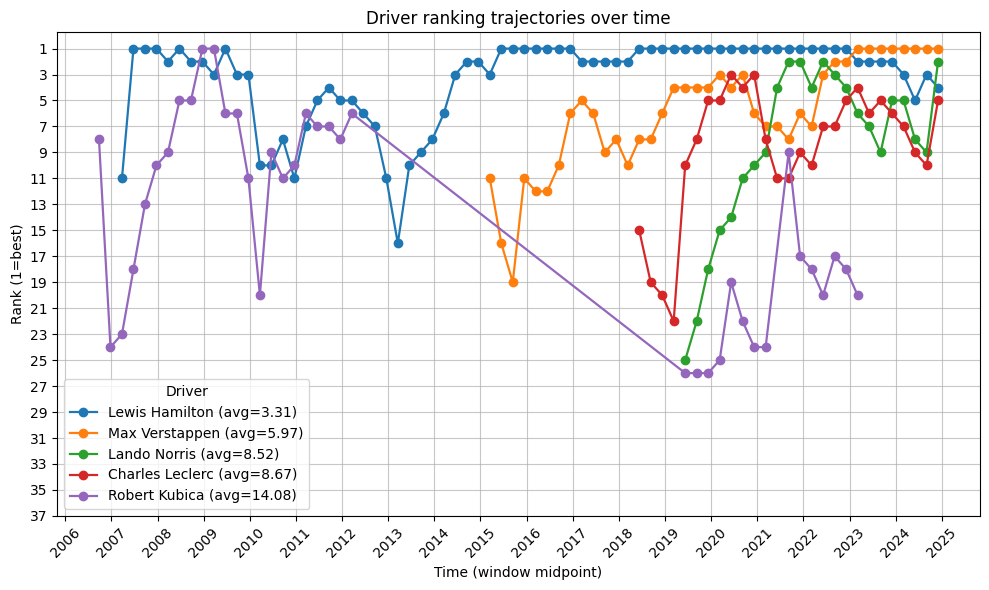

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plot_driver_trajectories(hist_df, driver_names, start=None, end=None, use_percentile=False):
    """
    Draws ranking trajectories for given driver names.
    driver_names: list of strings, must match hist_df['driver_name']
    """
    df = hist_df.copy()
    if start is not None:
        df = df[df["t"] >= pd.to_datetime(start)]
    if end is not None:
        df = df[df["t"] < pd.to_datetime(end)]

    metric = "rank_pct" if use_percentile else "rank"
    ylabel = "Rank percentile (0=best)" if use_percentile else "Rank (1=best)"

    plt.figure(figsize=(10, 6))
    for name in driver_names:
        g = df[df["driver_name"] == name].sort_values("t")
        if g.empty:
            continue
        mean_val = g[metric].mean()
        plt.plot(g["t"], g[metric], marker="o", linewidth=1.6,
                 label=f"{name} (avg={mean_val:.2f})")

    if not use_percentile:
        plt.gca().invert_yaxis()

    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)
    plt.yticks(range(1, int(df["n_active"].max()) + 1, 2))
    plt.title("Driver ranking trajectories over time")
    plt.xlabel("Time (window midpoint)")
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.7)
    plt.legend(title="Driver", fontsize=10)
    plt.tight_layout()
    plt.show()



min_periods = 5*3

# policz średnią pozycję i liczbę okresów (okien) dla każdego kierowcy
agg = (hist_df
       .groupby("driver_name")
       .agg(mean_rank=("rank", "mean"),
            periods=("t", "count"))
       .reset_index())

# zostaw tylko tych, którzy występowali w >= 5 okresach
eligible = agg[agg["periods"] >= min_periods]

# posortuj po średnim ranku (1 = najlepszy)
top_drivers = eligible.sort_values("mean_rank").head(4)
top5_names = top_drivers["driver_name"].tolist()
top5_names.append('Robert Kubica')  # dodatkowo pokaż Kubicę jako ciekawostkę

plot_driver_trajectories(
    hist_df,
    driver_names=top5_names,
    start="2000-01-01",
    end="2025-01-01",
    use_percentile=False,
)

In [ ]:
""